# Tutorial: Braking behavior analysis.

In [415]:
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# whether use Chinese
CHN = False 
if CHN:
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['font.sans-serif'] = ['SimSun']
else:
    plt.rcParams['font.sans-serif'] = ['Arial']
    
# colors
BLUE = '#2878B5'
LIGHTBLUE = '#9AC9DB'
ORANGE = '#F8AC8C'
RED = '#C82423'
PINK = '#FF8884'
GREY = '#9E9E9E'
DEEPGREEN = '#32B897'
GREEN = '#96CCCB'

LABEL_FONT = {
    "fontsize": 12,
    "weight": "bold",
}
plt.rcParams['figure.dpi'] = 150


## Trip aggregation data

In [416]:
import pickle
# with open("Z://Data/NEE_Chengdu/agg/agg_trip_20161101.pkl", 'rb') as f:
with open("E://agg_trip_20161120.pkl", 'rb') as f:
    agg_trip = pickle.load(f)

agg_trip = agg_trip[~(agg_trip['brakeCount'] == 0)].copy()
agg_trip = agg_trip[(agg_trip['trajCount'] >= 30)].copy()
# agg_trip = agg_trip[(agg_trip['mileage'] <= 2) & (agg_trip['mileage'] >= 0.05)].copy()  # 100m - 1km

agg_trip['brakeDecelMean'] = agg_trip['brakeDecelMean'].apply(np.abs)
agg_trip['brakeFrac'] = agg_trip['brakeCount'] / agg_trip['trajCount']

In [417]:
agg_trip.head()

,vehID,startHour,trajCount,brakeCount,mileage,speedMean,VSPMean,brakeDecelMean,OpModeCount,brakeFrac
0,0.0,18,31,12,0.215722,25.123833,0.348683,0.354190,"[0, 0, 11, 18, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.387097
1,0.0,18,31,22,0.180829,21.123951,0.071237,0.408326,"[1, 0, 20, 6, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,...",0.709677
3,0.0,18,31,12,0.028261,3.092522,0.183456,0.256128,"[0, 20, 6, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.387097
4,0.0,18,31,12,0.032200,3.907912,-0.217439,0.396788,"[1, 20, 6, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.387097
5,0.0,18,31,8,0.183482,20.953917,0.951271,0.795573,"[3, 0, 6, 14, 5, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0,...",0.258065


We got 358,017 trips on Nov.1 (Tuesday) with braking events and 410,258 on Nov.4 (Friday).

In [418]:
agg_trip.shape

(2482944, 10)

## Emission calculation

In [419]:
OpModeERs = np.load("./data/agg/OpModeERs.npy")
agg_trip['ER'] = agg_trip.apply(lambda x: sum(x['OpModeCount'] / x['trajCount'] * OpModeERs), axis=1)

## Relational analysis

### Speed vs braking

In [420]:
# obtain the braking fraction under different speed conditions
speedBins = np.arange(0, 110, 10)  # 0 - 100
brakeFrac_speed_mean = [agg_trip[(agg_trip['speedMean'] >= minV) & (agg_trip['speedMean'] < maxV)]['brakeFrac'].mean() for minV, maxV in zip(speedBins[:-1], speedBins[1:])]
brakeFrac_speed_std = [agg_trip[(agg_trip['speedMean'] >= minV) & (agg_trip['speedMean'] < maxV)]['brakeFrac'].std() for minV, maxV in zip(speedBins[:-1], speedBins[1:])]

decel_speed_mean = [agg_trip[(agg_trip['speedMean'] >= minV) & (agg_trip['speedMean'] < maxV)]['brakeDecelMean'].mean() for minV, maxV in zip(speedBins[:-1], speedBins[1:])]
decel_speed_std = [agg_trip[(agg_trip['speedMean'] >= minV) & (agg_trip['speedMean'] < maxV)]['brakeDecelMean'].std() for minV, maxV in zip(speedBins[:-1], speedBins[1:])]

brakeFracBins = np.arange(0, 1.1, 0.1)
decel_brakeFrac_mean = [agg_trip[(agg_trip['brakeFrac'] >= minV) & (agg_trip['brakeFrac'] < maxV)]['brakeDecelMean'].mean() for minV, maxV in zip(brakeFracBins[:-1], brakeFracBins[1:])]
decel_brakeFrac_std = [agg_trip[(agg_trip['brakeFrac'] >= minV) & (agg_trip['brakeFrac'] < maxV)]['brakeDecelMean'].std() for minV, maxV in zip(brakeFracBins[:-1], brakeFracBins[1:])]

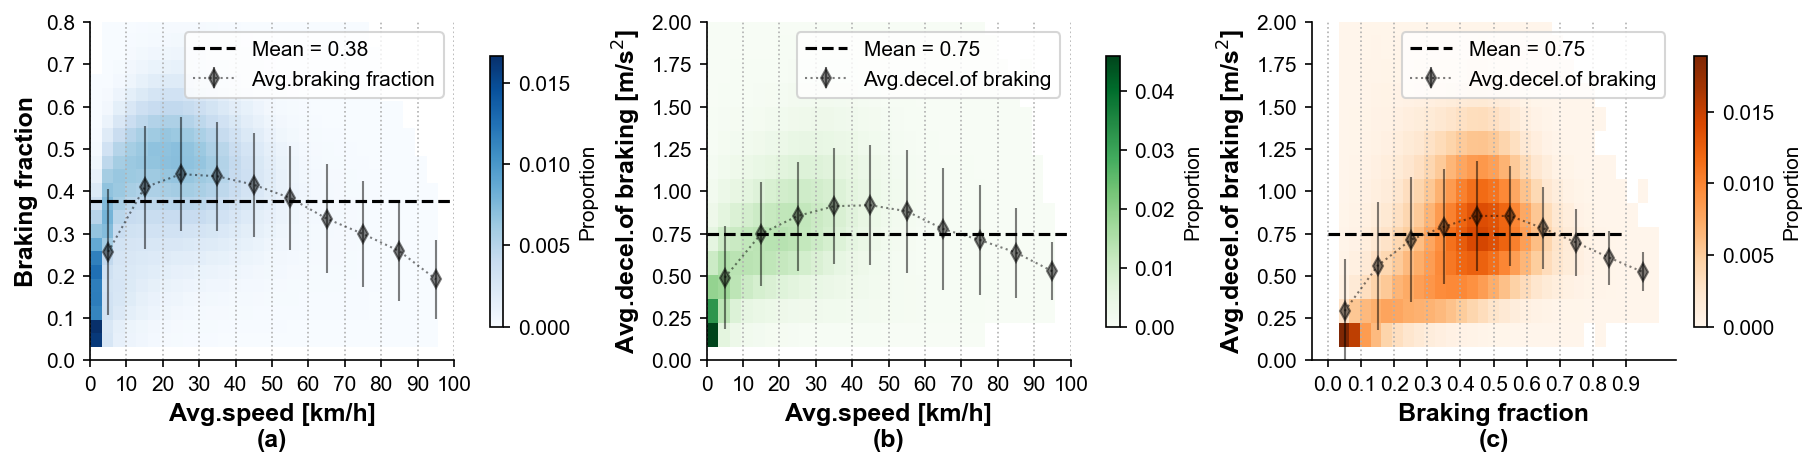

In [421]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3), constrained_layout=True)

# fig1: brakeFrac speed
sns.histplot(
    agg_trip, x="speedMean", y='brakeFrac', bins=30, stat='proportion',
    fill=True, ax=ax[0],
    cmap='Blues', cbar=True, cbar_kws=dict(location='right', shrink=0.8, label="Proportion"),
)
ax[0].errorbar(
    speedBins[:-1]+5, brakeFrac_speed_mean, brakeFrac_speed_std,
    color='k', linestyle='dotted', linewidth=1, marker='d', alpha=0.5,
    label='Avg.braking fraction'
)
ax[0].hlines(
    agg_trip['brakeFrac'].mean(), 0, 100,
    colors='k', linestyles='dashed',
    label='Mean = %.2f' % agg_trip['brakeFrac'].mean()
)
ax[0].set_xlabel("Avg.speed [km/h]\n(a)", fontdict=LABEL_FONT)
ax[0].set_xticks(np.arange(0,110,10))
ax[0].set_ylabel("Braking fraction", fontdict=LABEL_FONT)
ax[0].set_xlim(0,100)
ax[0].set_ylim(0, 0.8)
ax[0].legend()
ax[0].grid(axis='x', linestyle=":")

# fig 2: brake decel - speed
sns.histplot(
    agg_trip, x="speedMean", y='brakeDecelMean', bins=30, stat='proportion',
    fill=True, ax=ax[1],
    cmap='Greens', cbar=True, cbar_kws=dict(location='right', shrink=0.8, label="Proportion")
)
ax[1].errorbar(
    speedBins[:-1]+5, decel_speed_mean, decel_speed_std,
    color='k', linestyle='dotted', linewidth=1, marker='d', alpha=0.5,
    label='Avg.decel.of braking'
)
ax[1].hlines(
    agg_trip['brakeDecelMean'].mean(), 0, 100,
    colors='k', linestyles='dashed',
    label='Mean = %.2f' % agg_trip['brakeDecelMean'].mean()
)
ax[1].set_xlabel("Avg.speed [km/h]\n(b)", fontdict=LABEL_FONT)
ax[1].set_xticks(np.arange(0,110,10))
ax[1].set_ylabel("Avg.decel.of braking [m/s$^2$]", fontdict=LABEL_FONT)
ax[1].set_ylim(0, 2)
ax[1].set_xlim(0,100)
ax[1].legend()
ax[1].grid(axis='x', linestyle=":")

# fig 3: brakeFrac - brake decel grid
sns.histplot(
    agg_trip, x="brakeFrac", y='brakeDecelMean', bins=30, stat='proportion',
    fill=True, ax=ax[2],
    cmap='Oranges', cbar=True, cbar_kws=dict(location='right', shrink=0.8, label="Proportion")
)
ax[2].errorbar(
    brakeFracBins[:-1]+0.05, decel_brakeFrac_mean, decel_brakeFrac_std,
    color='k', linestyle='dotted', linewidth=1, marker='d', alpha=0.5,
    label='Avg.decel.of braking'
)
ax[2].hlines(
    agg_trip['brakeDecelMean'].mean(), 0, 0.9,
    colors='k', linestyles='dashed',
    label='Mean = %.2f' % agg_trip['brakeDecelMean'].mean()
)
ax[2].set_xlabel("Braking fraction\n(c)", fontdict=LABEL_FONT)
ax[2].set_xticks(np.arange(0, 1, 0.1))
ax[2].set_ylabel("Avg.decel.of braking [m/s$^2$]", fontdict=LABEL_FONT)
ax[2].set_ylim(0, 2)
ax[2].legend()
ax[2].grid(axis='x', linestyle=":")

for ax_ in ax:
    ax_.spines['top'].set_visible(False)
    ax_.spines['right'].set_visible(False)

plt.show()

### Braking vs ER

In [422]:
# # calculate correlation
# corr = agg_trip[['ER', 'speedMean', 'brakeDecelMean', 'VSPMean', 'brakeFrac']].corr(method='spearman').loc['ER']

In [423]:
# obtain the average braking fraction under different speed bins
speedBins = np.arange(0, 110, 10)
ER_speed_mean = [agg_trip[(agg_trip['speedMean'] >= minV) & (agg_trip['speedMean'] < maxV)]['ER'].mean() for minV, maxV in zip(speedBins[:-1], speedBins[1:])]
ER_speed_std = [agg_trip[(agg_trip['speedMean'] >= minV) & (agg_trip['speedMean'] < maxV)]['ER'].std() for minV, maxV in zip(speedBins[:-1], speedBins[1:])]

decelBins = np.arange(0, 3.2, 0.4)
ER_decel_mean = [agg_trip[(agg_trip['brakeDecelMean'] >= minV) & (agg_trip['brakeDecelMean'] < maxV)]['ER'].mean() for minV, maxV in zip(decelBins[:-1], decelBins[1:])]
ER_decel_std = [agg_trip[(agg_trip['brakeDecelMean'] >= minV) & (agg_trip['brakeDecelMean'] < maxV)]['ER'].std() for minV, maxV in zip(decelBins[:-1], decelBins[1:])]

brakeFracBins = np.arange(0, 1.2, 0.2)
ER_brakeFrac_mean = [agg_trip[(agg_trip['brakeFrac'] >= minV) & (agg_trip['brakeFrac'] < maxV)]['ER'].mean() for minV, maxV in zip(brakeFracBins[:-1], brakeFracBins[1:])]
ER_brakeFrac_std = [agg_trip[(agg_trip['brakeFrac'] >= minV) & (agg_trip['brakeFrac'] < maxV)]['ER'].std() for minV, maxV in zip(brakeFracBins[:-1], brakeFracBins[1:])]

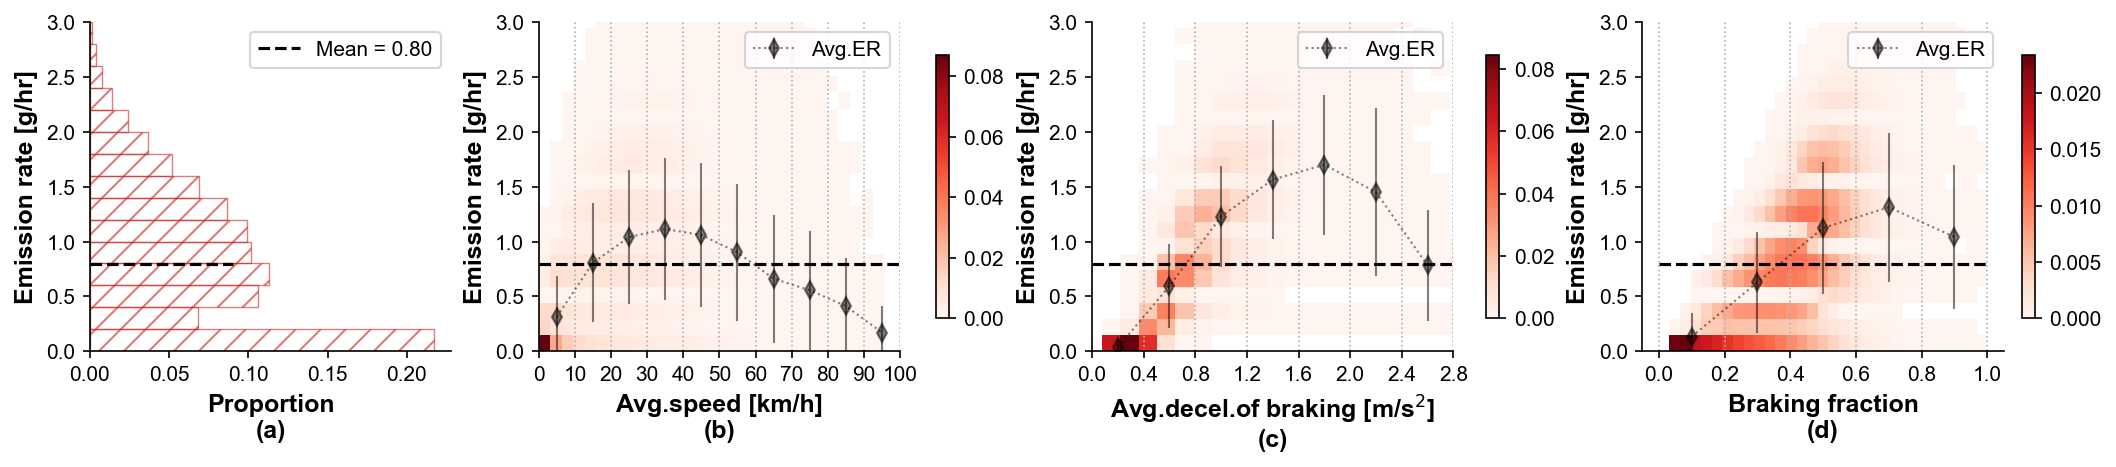

In [425]:
fig, ax = plt.subplots(1, 4, figsize=(14,3), constrained_layout=True)

# ER dist
sns.histplot(
    agg_trip, y="ER", binwidth=0.2, stat='proportion',
    element='bars', fill=False,  hatch='//', color=RED, alpha=0.6, ax=ax[0]
)
ax[0].hlines(
    agg_trip['ER'].mean(), 0, 0.09,
    colors='k', linestyles='dashed',
    label='Mean = %.2f' % agg_trip['ER'].mean()
)
ax[0].legend()
ax[0].set_xlabel("Proportion\n(a)", fontdict=LABEL_FONT)
ax[0].set_ylabel("Emission rate [g/hr]", fontdict=LABEL_FONT)

# speed - ER contour
sns.histplot(
    agg_trip, x="speedMean", y='ER', bins=30, stat='proportion',
    fill=True, ax=ax[1],
    cmap='Reds', cbar=True, cbar_kws=dict(location='right', shrink=0.8)
)
ax[1].errorbar(
    speedBins[:-1]+5, ER_speed_mean, ER_speed_std,
    color='k', linestyle='dotted', linewidth=1, marker='d', alpha=0.5,
    label='Avg.ER'
)
ax[1].hlines(
    agg_trip['ER'].mean(), 0, 100,
    colors='k', linestyles='dashed',
)
ax[1].set_xlabel("Avg.speed [km/h]\n(b)", fontdict=LABEL_FONT)
ax[1].set_xticks(np.arange(0,110,10))
ax[1].set_ylabel("Emission rate [g/hr]", fontdict=LABEL_FONT)
ax[1].set_xlim(0,100)
ax[1].legend()
ax[1].grid(axis='x', linestyle=":")

# brake decel - ER contour
sns.histplot(
    agg_trip, x="brakeDecelMean", y='ER', bins=30, stat='proportion',
    fill=True, ax=ax[2],
    cmap='Reds', cbar=True, cbar_kws=dict(location='right', shrink=0.8)
)
ax[2].errorbar(
    decelBins[:-1]+0.2, ER_decel_mean, ER_decel_std,
    color='k', linestyle='dotted', linewidth=1, marker='d', alpha=0.5,
    label='Avg.ER'
)
ax[2].hlines(
    agg_trip['ER'].mean(), 0, 3,
    colors='k', linestyles='dashed',
)
ax[2].set_xlabel("Avg.decel.of braking [m/s$^2$]\n(c)", fontdict=LABEL_FONT)
ax[2].set_xticks(np.arange(0,3.2,0.4))
ax[2].set_ylabel("Emission rate [g/hr]", fontdict=LABEL_FONT)
ax[2].set_xlim(0, 2.8)
ax[2].legend()
ax[2].grid(axis='x', linestyle=":")

# speed - ER contour
sns.histplot(
    agg_trip, x="brakeFrac", y='ER', bins=30, stat='proportion',
    fill=True, ax=ax[3],
    cmap='Reds', cbar=True, cbar_kws=dict(location='right', shrink=0.8)
)
ax[3].errorbar(
    brakeFracBins[:-1]+0.1, ER_brakeFrac_mean, ER_brakeFrac_std,
    color='k', linestyle='dotted', linewidth=1, marker='d', alpha=0.5,
    label='Avg.ER'
)
ax[3].hlines(
    agg_trip['ER'].mean(), 0, 1.0,
    colors='k', linestyles='dashed',
)
ax[3].set_xlabel("Braking fraction\n(d)", fontdict=LABEL_FONT)
ax[3].set_xticks(np.arange(0,1.2,0.2))
ax[3].set_ylabel("Emission rate [g/hr]", fontdict=LABEL_FONT)
ax[3].legend()
ax[3].grid(axis='x', linestyle=":")

for ax_ in ax:
    ax_.spines['top'].set_visible(False)
    ax_.spines['right'].set_visible(False)
    ax_.set_ylim(0, 3)

plt.show()

In [ ]:
agg_trip[agg_trip['']]

## Modeling

---

## When would braking fraction be higher?

Now we want to explore the following problems:
1. What's the behavior characteristics of high braking fraction trips?
2. What relationship do they have with braking fraction?
3. How to explain the higher braking fraction in off-peak period than peak period?

First, trips are divided to two sets according to the braking fraction and analyse the difference between them.

In [ ]:
# # obtain the braking fraction under different conditions
# speedBins = np.arange(0, 105, 5)
# brakeFrac_speed_mean = [agg_trip[(agg_trip['speedMean'] >= minV) & (agg_trip['speedMean'] < maxV)]['brakeFrac'].mean() for minV, maxV in zip(speedBins[:-1], speedBins[1:])]
# brakeFrac_speed_std = [agg_trip[(agg_trip['speedMean'] >= minV) & (agg_trip['speedMean'] < maxV)]['brakeFrac'].std() for minV, maxV in zip(speedBins[:-1], speedBins[1:])]

# decelBins = np.arange(0, 3.2, 0.2)
# brakeFrac_decel_mean = [agg_trip[(agg_trip['brakeDecelMean'] >= minV) & (agg_trip['brakeDecelMean'] < maxV)]['brakeFrac'].mean() for minV, maxV in zip(decelBins[:-1], decelBins[1:])]
# brakeFrac_decel_std = [agg_trip[(agg_trip['brakeDecelMean'] >= minV) & (agg_trip['brakeDecelMean'] < maxV)]['brakeFrac'].std() for minV, maxV in zip(decelBins[:-1], decelBins[1:])]

# brakeFrac_grid = [
#     [agg_trip[
#         (agg_trip['speedMean'] >= minV)
#         & (agg_trip['speedMean'] < maxV)
#         & (agg_trip['brakeDecelMean'] >= minD)
#         & (agg_trip['brakeDecelMean'] < maxD)]['brakeFrac'].mean()
#         for minV, maxV in zip(speedBins[:-1], speedBins[1:])]
#     for minD, maxD in zip(decelBins[:-1], decelBins[1:])]

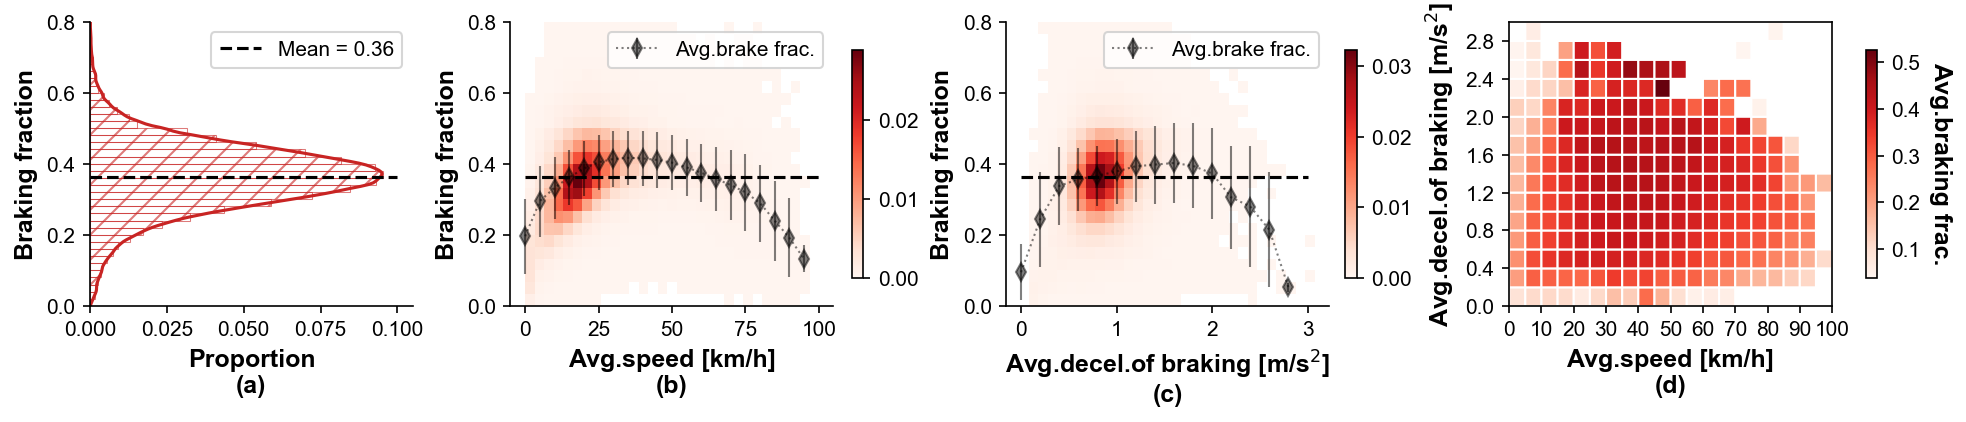

In [ ]:
# fig, ax = plt.subplots(1, 4, figsize=(13,2.7), constrained_layout=True)

# # brakeFrac dist
# sns.histplot(
#     agg_trip, y="brakeFrac", kde=True, binwidth=0.02, stat='proportion',
#     element='bars', fill=False,  hatch='//', color=RED, alpha=0.6, ax=ax[0]
# )
# ax[0].hlines(
#     agg_trip['brakeFrac'].mean(), 0, 0.1,
#     colors='k', linestyles='dashed',
#     label='Mean = %.2f' % agg_trip['brakeFrac'].mean()
# )
# ax[0].legend()
# ax[0].set_xlabel("Proportion\n(a)", fontdict=LABEL_FONT)
# ax[0].set_ylabel("Braking fraction", fontdict=LABEL_FONT)

# # speed - brakeFrac
# sns.histplot(
#     agg_trip, x="speedMean", y='brakeFrac', bins=30, stat='proportion',
#     fill=True, ax=ax[1],
#     cmap='Reds', cbar=True, cbar_kws=dict(location='right', shrink=0.8)
# )
# ax[1].errorbar(
#     speedBins[:-1], brakeFrac_speed_mean, brakeFrac_speed_std,
#     color='k', linestyle='dotted', linewidth=1, marker='d', alpha=0.5,
#     label='Avg.brake frac.'
# )
# ax[1].hlines(
#     agg_trip['brakeFrac'].mean(), 0, 100,
#     colors='k', linestyles='dashed',
# )
# # ax[1].set_title("Spearman corr. = %.2f" % corr['speedMean'])
# ax[1].set_xlabel("Avg.speed [km/h]\n(b)", fontdict=LABEL_FONT)
# ax[1].set_ylabel("Braking fraction", fontdict=LABEL_FONT)
# ax[1].legend()

# # brake decel - ER contour
# sns.histplot(
#     agg_trip, x="brakeDecelMean", y='brakeFrac', bins=30, stat='proportion',
#     fill=True, ax=ax[2],
#     cmap='Reds', cbar=True, cbar_kws=dict(location='right', shrink=0.8)
# )
# ax[2].errorbar(
#     decelBins[:-1], brakeFrac_decel_mean, brakeFrac_decel_std,
#     color='k', linestyle='dotted', linewidth=1, marker='d', alpha=0.5,
#     label='Avg.brake frac.'
# )
# ax[2].hlines(
#     agg_trip['brakeFrac'].mean(), 0, 3,
#     colors='k', linestyles='dashed',
# )
# # ax[2].set_title("Spearman corr. = %.2f" % corr['brakeDecelMean'])
# ax[2].set_xlabel("Avg.decel.of braking [m/s$^2$]\n(c)", fontdict=LABEL_FONT)
# ax[2].set_ylabel("Braking fraction", fontdict=LABEL_FONT)
# ax[2].legend()

# # heatmap
# img = ax[3].pcolor(
#     brakeFrac_grid,
#     cmap='Reds', linewidths=1, edgecolors='white'
# )
# cbar = fig.colorbar(img, ax=ax[3], location='right', shrink=0.8)
# cbar.set_label('Avg.braking frac.', rotation=-90, va="bottom", fontdict=LABEL_FONT)

# ax[3].set_xlabel("Avg.speed [km/h]\n(d)", fontdict=LABEL_FONT)
# ax[3].set_xticks(np.arange(0, len(speedBins), 2))
# ax[3].set_xticklabels(np.arange(0, 110, 10))

# ax[3].set_ylabel("Avg.decel.of braking [m/s$^2$]", fontdict=LABEL_FONT)
# ax[3].set_yticks(np.arange(0, len(decelBins), 2))
# ax[3].set_yticklabels(["%.1f" % d for d in np.arange(0, 3.2, 0.4)])

# for ax_ in ax[:3]:
#     ax_.spines['top'].set_visible(False)
#     ax_.spines['right'].set_visible(False)
#     ax_.set_ylim(0, 0.8)

# plt.show()